### 1. Realized Volatility

### Step 1

In [1]:
import datetime as dt
import math
import pandas as pd
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
from skfolio.datasets import load_sp500_dataset, load_sp500_implied_vol_dataset
from statsmodels.tsa.stattools import coint

TRADING_DAYS = 252
START_DATE = "2010-01-01"
END_DATE = "2025-03-05"  # Fixed as per assignment
TICKER = "AAPL"
WINDOW = 30  # Rolling window size

#### Step 2

Download daily price data to plot estimators for mean and realized variance.

In [8]:
# AAPL data 
aapl_data = yf.download(TICKER, start=START_DATE, end=END_DATE)

# SPX data 
spx_data = yf.download("^GSPC", start=START_DATE, end=END_DATE)

# VIX data
vix_data = yf.download("^VIX", start=START_DATE, end=END_DATE)

print(f"  AAPL: {len(aapl_data)} rows ({aapl_data.index[0].date()} to {aapl_data.index[-1].date()})")
print(f"  SPX:  {len(spx_data)} rows")
print(f"  VIX:  {len(vix_data)} rows")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

  AAPL: 3815 rows (2010-01-04 to 2025-03-04)
  SPX:  3815 rows
  VIX:  3815 rows


In [9]:
# Extract price series

aapl_close = aapl_data["Close"].squeeze() # flatten columns
aapl_high = aapl_data["High"].squeeze()
aapl_low = aapl_data["Low"].squeeze()
aapl_open = aapl_data["Open"].squeeze()

spx_close = spx_data["Close"].squeeze()
vix_close = vix_data["Close"].squeeze() / 100  # Convert to decimal

aapl_returns = aapl_close.pct_change().dropna()
spx_returns = spx_close.pct_change().dropna()

#### Step 3: Historical Estimators

Compute the classical historical mean and volatility estimators.

In [10]:
# Estimating the drift parameter and volatility

N = len(aapl_returns)
delta_t = 1 / TRADING_DAYS  # Daily time increment in years
T_years = N * delta_t  # Total time span in years

# Drift
mu_hat = aapl_returns.mean() / delta_t

# Volatility Estimator
term1 = (1 / (N - 1)) * (1 / delta_t) * (aapl_returns ** 2).sum()
term2 = (T_years / (N - 1)) * (mu_hat ** 2)
sigma_hat = np.sqrt(term1 - term2)

print(f"Sample size (N):        {N}")
print(f"Time span:              {T_years:.2f} years")
print(f"Annualized drift:       {mu_hat:.4f} ({mu_hat*100:.2f}%)")
print(f"Annualized vol:         {sigma_hat:.4f} ({sigma_hat*100:.2f}%)")

Sample size (N):        3814
Time span:              15.13 years
Annualized drift:       0.2769 (27.69%)
Annualized vol:         0.2786 (27.86%)


In [17]:
def classical_volatility_window(returns, window, delta_t, T_years):
    N = window
    mu_hat = returns.rolling(window=N).sum() / T_years
    
    sum_sq_returns = (returns**2).rolling(window=N).sum()
    term1 = (1 / (N - 1)) * (1 / delta_t) * sum_sq_returns
    
    term2 = (T_years / (N - 1)) * (mu_hat**2)
    sigma_sq = term1 - term2
    return np.sqrt(sigma_sq.clip(lower=0))

Implement one alternative volatility estimator of your choice (e.g. Parkinson or GK) and compare it with the classical volatility estimator.

In [11]:
# GK Estimator for comparison

T_days = len(aapl_close)

log_hl_sq = np.log(aapl_high / aapl_low) ** 2
log_co_sq = np.log(aapl_close / aapl_open) ** 2

gk_term1 = (1 / (2 * T_days)) * log_hl_sq.sum()
gk_term2 = ((2 * np.log(2) - 1) / T_days) * log_co_sq.sum()

sigma_gk_daily = np.sqrt(gk_term1 - gk_term2)
sigma_gk = sigma_gk_daily * np.sqrt(TRADING_DAYS)  # Annualize

print(f"Daily volatility:       {sigma_gk_daily:.6f}")
print(f"Annualized volatility:  {sigma_gk:.4f} ({sigma_gk*100:.2f}%)")

print(f"Classical:              {sigma_hat:.4f}")
print(f"Garman-Klass:           {sigma_gk:.4f}")
print(f"Difference:             {abs(sigma_hat - sigma_gk):.4f}")

Daily volatility:       0.014019
Annualized volatility:  0.2225 (22.25%)
Classical:              0.2786
Garman-Klass:           0.2225
Difference:             0.0561


Compute a rolling window estimator using a 30-day window. Plot the results for all estimators and explain your findings.

In [13]:
# Rolling window estimators

rolling_classical = aapl_returns.rolling(window=WINDOW).std() * np.sqrt(TRADING_DAYS)

def compute_rolling_gk(log_hl_sq, log_co_sq, window):
    """Compute rolling Garman-Klass volatility."""
    n = window
    term1 = (1 / (2 * n)) * log_hl_sq.rolling(window=n).sum()
    term2 = ((2 * np.log(2) - 1) / n) * log_co_sq.rolling(window=n).sum()
    daily_var = term1 - term2
    return np.sqrt(daily_var.clip(lower=0)) * np.sqrt(TRADING_DAYS)

rolling_gk = compute_rolling_gk(log_hl_sq, log_co_sq, WINDOW)

# Rolling drift
rolling_mu = aapl_returns.rolling(window=WINDOW).mean() * TRADING_DAYS

print(f"Rolling {WINDOW}-Day Estimator Statistics:")
print(f"Classical Vol  - Mean Volatility: {rolling_classical.mean():.4f}, Std: {rolling_classical.std():.4f}")
print(f"Garman-Klass   - Mean Volatility: {rolling_gk.mean():.4f}, Std: {rolling_gk.std():.4f}")
print(f"Drift          - Mean:            {rolling_mu.mean():.4f}, Std: {rolling_mu.std():.4f}")

Rolling 30-Day Estimator Statistics:
Classical Vol  - Mean Volatility: 0.2593, Std: 0.1026
Garman-Klass   - Mean Volatility: 0.2092, Std: 0.0751
Drift          - Mean:            0.2819, Std: 0.7761


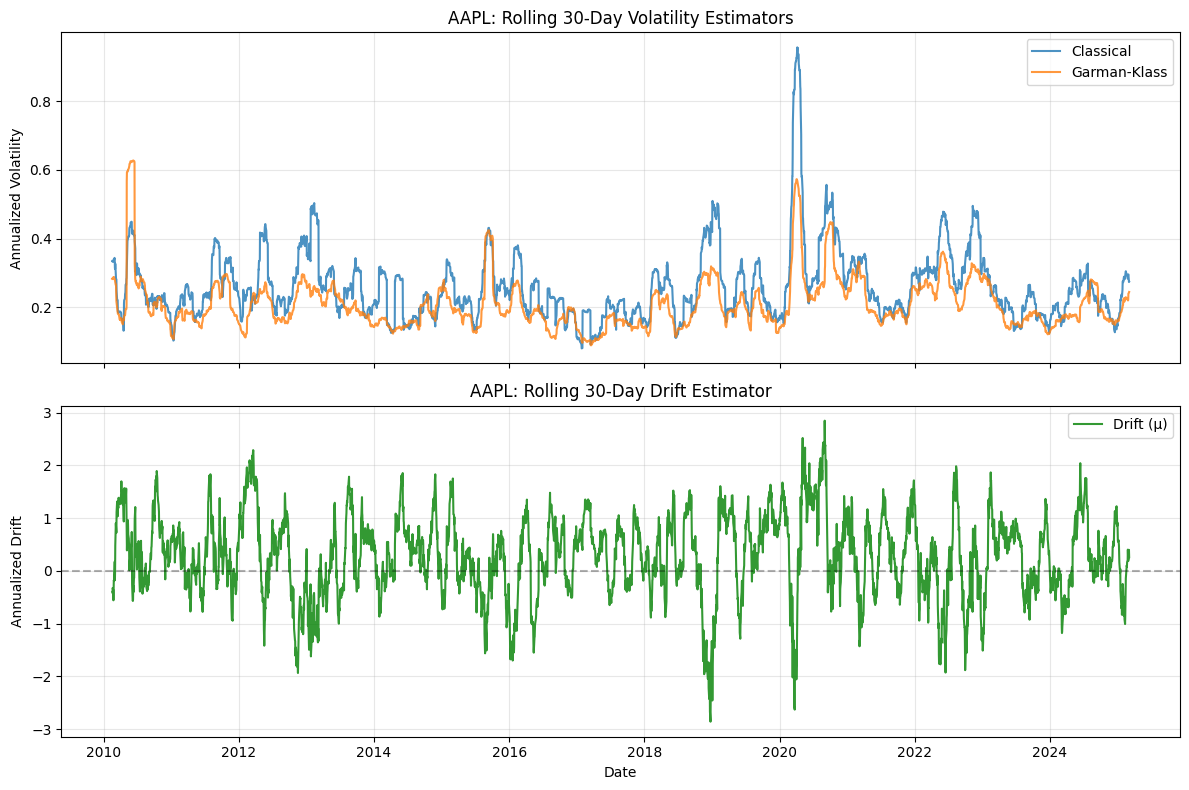

In [24]:
# Plot Rolling Estimators
fig, axes = plt.subplots(2, 1, figsize=(12, 8), sharex=True)

# Plot 1: Volatility estimators
axes[0].plot(rolling_classical.index, rolling_classical, label='Classical', alpha=0.8)
axes[0].plot(rolling_gk.index, rolling_gk, label='Garman-Klass', alpha=0.8)
axes[0].set_ylabel('Annualized Volatility')
axes[0].set_title(f'{TICKER}: Rolling {WINDOW}-Day Volatility Estimators')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Drift estimator
axes[1].plot(rolling_mu.index, rolling_mu, label='Drift (μ)', color='green', alpha=0.8)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.3)
axes[1].set_ylabel('Annualized Drift')
axes[1].set_xlabel('Date')
axes[1].set_title(f'{TICKER}: Rolling {WINDOW}-Day Drift Estimator')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Select one of the S&P500 stocks and comapare to the realized variance estimators with the time series of implied volatilities for a ticker. To retrieve implied volatility data, you can use the skfolio package.

In [18]:
prices_sk = load_sp500_dataset()
implied_vol_sk = load_sp500_implied_vol_dataset()

ticker_sk = "AAPL"

prices_ticker = prices_sk.loc["2010":, ticker_sk]
implied_vol_ticker = implied_vol_sk.loc["2010":, ticker_sk]

returns_sk = prices_ticker.pct_change().dropna()
window_size = 30
dt = 1 / 252      
T_win = window_size / 252  

realized_vol_sk = classical_volatility_window(
    returns_sk, 
    window=window_size, 
    delta_t=dt, 
    T_years=T_win
)

common_idx_sk = realized_vol_sk.dropna().index.intersection(implied_vol_ticker.dropna().index)
realized_vol_aligned = realized_vol_sk.loc[common_idx_sk]
implied_vol_aligned = implied_vol_ticker.loc[common_idx_sk]

print(f"AAPL: Realized Vol vs Implied Vol (skfolio)")
print(f"Date range: {common_idx_sk[0].date()} to {common_idx_sk[-1].date()}")
print(f"Observations: {len(common_idx_sk)}")
print(f"\nRealized Vol - Mean: {realized_vol_aligned.mean():.4f}, Range: [{realized_vol_aligned.min():.4f}, {realized_vol_aligned.max():.4f}]")
print(f"Implied Vol  - Mean: {implied_vol_aligned.mean():.4f}, Range: [{implied_vol_aligned.min():.4f}, {implied_vol_aligned.max():.4f}]")
print(f"Correlation: {realized_vol_aligned.corr(implied_vol_aligned):.4f}")

AAPL: Realized Vol vs Implied Vol (skfolio)
Date range: 2010-02-17 to 2022-12-28
Observations: 3240

Realized Vol - Mean: 0.2662, Range: [0.0807, 0.9560]
Implied Vol  - Mean: 0.2863, Range: [0.1663, 0.7279]
Correlation: 0.6769


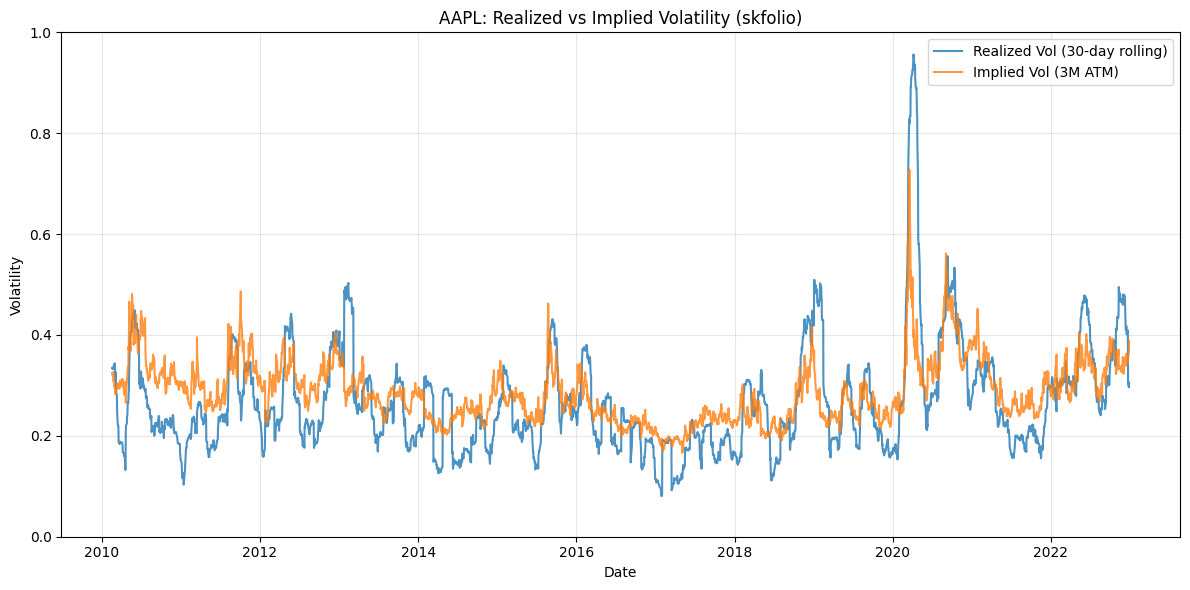

In [26]:
# Plot: Realized Vol vs Implied Vol (stock-specific)
fig, ax = plt.subplots(figsize=(12, 6))
ax.plot(realized_vol_aligned.index, realized_vol_aligned, label='Realized Vol (30-day rolling)', alpha=0.8)
ax.plot(implied_vol_aligned.index, implied_vol_aligned, label='Implied Vol (3M ATM)', alpha=0.8)
ax.set_ylabel('Volatility')
ax.set_xlabel('Date')
ax.set_title(f'{ticker_sk}: Realized vs Implied Volatility (skfolio)')
ax.legend()
ax.grid(True, alpha=0.3)
ax.set_ylim(0, 1)
plt.tight_layout()
plt.show()

### Step 4: Implied Volatility Data and VIX Estimation

Download the SPX and VIX quoted data for the specified time window

In [27]:
# Fetch SPX data
reference_date = pd.to_datetime("2025-03-04") 
S0 = float(spx_close.loc[:reference_date].iloc[-1])
vix_market = float(vix_data["Close"].squeeze().loc[:reference_date].iloc[-1])
r = 0.02  # Risk-free rate
T_vix = 30 / 365.0  # 30 days to expiry
F0 = S0 * math.exp(r * T_vix)  # Forward price

print(f"Reference date:         {reference_date.date()}")
print(f"Spot price (S0):        {S0:.2f}")
print(f"Forward price (F0):     {F0:.2f}")
print(f"Risk-free rate:         {r}")
print(f"Time to expiry:         {T_vix:.4f} years ({T_vix*365:.0f} days)")
print(f"Market VIX:             {vix_market:.2f}")


Reference date:         2025-03-04
Spot price (S0):        5778.15
Forward price (F0):     5787.66
Risk-free rate:         0.02
Time to expiry:         0.0822 years (30 days)
Market VIX:             23.51


In [28]:
# Load option data from CSV files
calls = pd.read_csv("data/Call_option_data_2025-04-03_final.csv")
puts = pd.read_csv("data/Put_option_data_2025-04-03_final.csv")

print("Calls:")
print(f"  Shape: {calls.shape}")
print(f"  Columns: {calls.columns.tolist()}")
print(calls.head())

print("\nPuts:")
print(f"  Shape: {puts.shape}")
print(f"  Columns: {puts.columns.tolist()}")
print(puts.head())

Calls:
  Shape: (124, 15)
  Columns: ['Unnamed: 0', 'contractSymbol', 'lastTradeDate', 'strike', 'Last', 'bid', 'ask', 'change', 'percentChange', 'volume', 'openInterest', 'impliedVolatility', 'inTheMoney', 'contractSize', 'currency']
   Unnamed: 0       contractSymbol              lastTradeDate  strike  \
0           0  SPXW250403C02800000  2025-04-03 02:35:56+00:00  2800.0   
1           1  SPXW250403C05100000  2025-04-02 19:46:46+00:00  5100.0   
2           2  SPXW250403C05150000  2025-04-03 02:48:42+00:00  5150.0   
3           3  SPXW250403C05200000  2025-04-03 16:40:04+00:00  5200.0   
4           4  SPXW250403C05400000  2025-04-03 17:15:38+00:00  5400.0   

      Last     bid     ask     change  percentChange  volume  openInterest  \
0  2713.28  2643.4  2661.6 -183.11987      -6.322327     1.0             1   
1   572.30   347.0   354.3    0.00000       0.000000     6.0             4   
2   366.97   296.5   304.2  -96.91000     -20.891178     1.0             3   
3   264.90   2

Compute the estimated VIX using the estimator $VIX_t$ (eq. 18) and compare it with the CBOE-quoted VIX.

In [29]:
def compute_vix_estimate(calls, puts, S0, r, T):
    """
    Compute VIX estimate using discretization.
    """
    # Forward price
    F0 = S0 * np.exp(r * T)
    
    # Compute mid prices
    calls = calls.copy()
    puts = puts.copy()
    calls['mid'] = (calls['bid'] + calls['ask']) / 2
    puts['mid'] = (puts['bid'] + puts['ask']) / 2
    
    # Filter OTM options (Puts: K < F0, Calls: K > F0)
    otm_puts = puts[puts['strike'] < F0].copy()
    otm_calls = calls[calls['strike'] > F0].copy()
    
    # Remove zero/NaN prices
    otm_puts = otm_puts[otm_puts['mid'] > 0].dropna(subset=['mid'])
    otm_calls = otm_calls[otm_calls['mid'] > 0].dropna(subset=['mid'])
    
    # Sort by strike
    otm_puts = otm_puts.sort_values('strike').reset_index(drop=True)
    otm_calls = otm_calls.sort_values('strike').reset_index(drop=True)
    
    # Extract arrays
    K_p, P = otm_puts['strike'].values, otm_puts['mid'].values
    K_c, C = otm_calls['strike'].values, otm_calls['mid'].values
    
    # Put contribution
    put_sum = sum(P[i] * (1/K_p[i] - 1/K_p[i+1]) for i in range(len(K_p) - 1))
    
    # Call contribution
    call_sum = sum(C[i] * (1/K_c[i-1] - 1/K_c[i]) for i in range(1, len(K_c)))
    
    # VIX^2 formula
    vix_squared = (2 * np.exp(r * T) / T) * (put_sum + call_sum)
    vix_estimate = np.sqrt(max(vix_squared, 0)) * 100  # Percentage
    
    return {
        'vix_estimate': vix_estimate,
        'F0': F0,
        'n_puts': len(otm_puts),
        'n_calls': len(otm_calls),
        'put_contribution': put_sum,
        'call_contribution': call_sum
    }

In [30]:
# Compute VIX estimate
results = compute_vix_estimate(calls, puts, S0, r, T_vix)

print("VIX ESTIMATION RESULTS")
print("=" * 50)
print(f"OTM Puts used:          {results['n_puts']}")
print(f"OTM Calls used:         {results['n_calls']}")
print("=" * 50)
print(f"Estimated VIX:          {results['vix_estimate']:.2f}%")
print(f"Market VIX (CBOE):      {vix_market:.2f}%")
print(f"Difference:             {results['vix_estimate'] - vix_market:.2f}%")

VIX ESTIMATION RESULTS
OTM Puts used:          132
OTM Calls used:         54
Estimated VIX:          20.51%
Market VIX (CBOE):      23.51%
Difference:             -3.00%


Plot the historical estimated realized variances from Step 3 alongside the VIX time series. 

Perform statistical analyses(such as correlation or cointegration tests) to assess the relationship between the time series.

In [31]:
# Align all series to common dates
common_idx = rolling_classical.dropna().index \
    .intersection(rolling_gk.dropna().index) \
    .intersection(vix_close.dropna().index)

rv_classical = rolling_classical.loc[common_idx]
rv_gk = rolling_gk.loc[common_idx]
vix_aligned = vix_close.loc[common_idx]

print(f"Data range: {common_idx[0].date()} to {common_idx[-1].date()}")
print(f"Observations: {len(common_idx)}")

Data range: 2010-02-17 to 2025-03-04
Observations: 3785


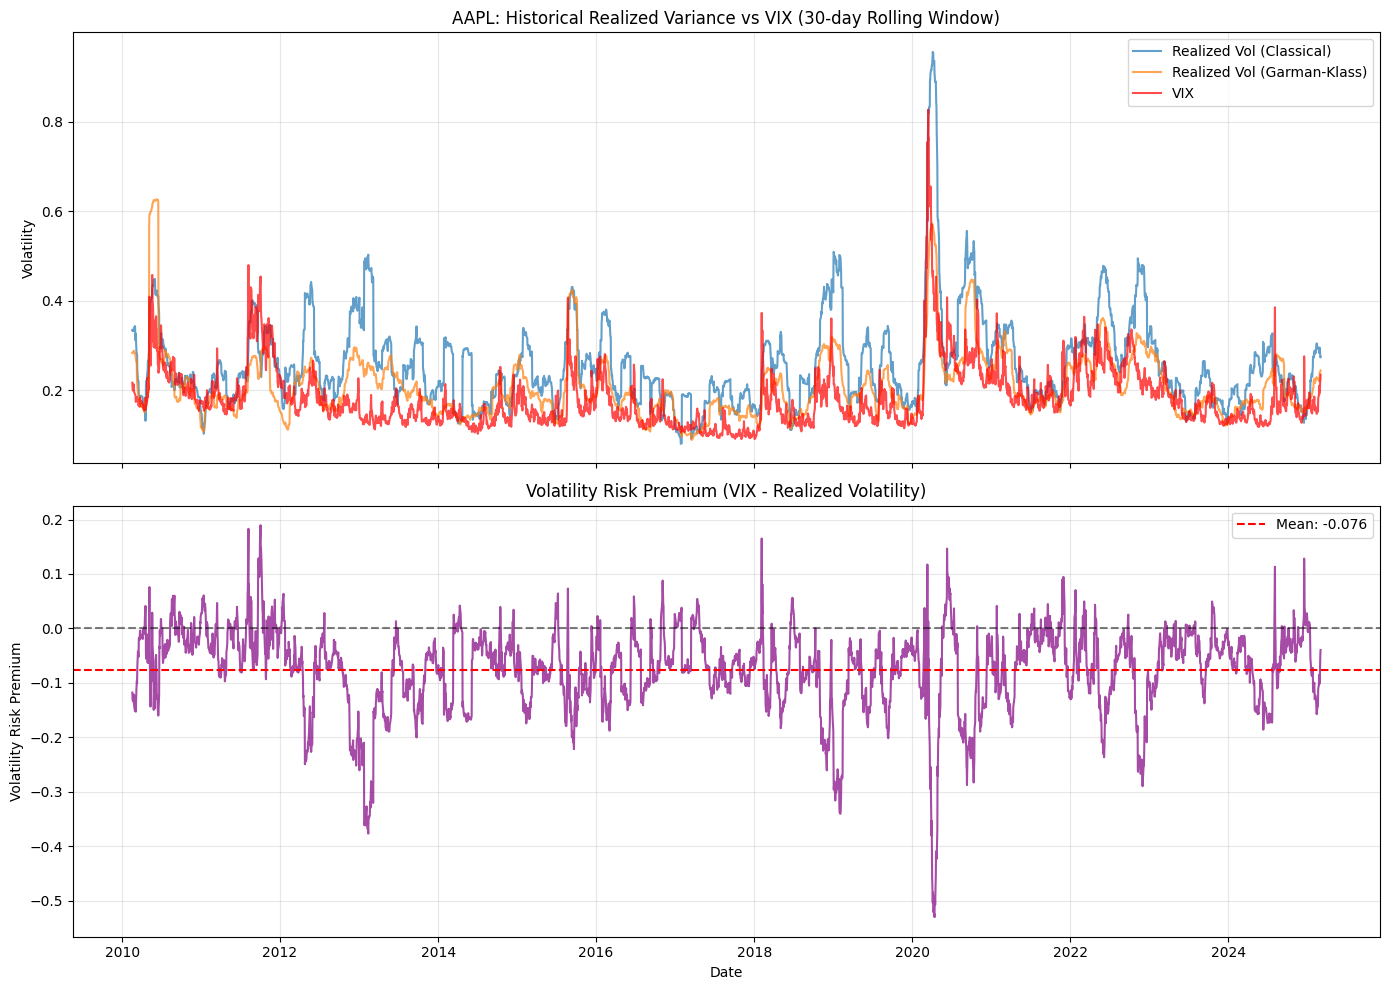

In [41]:
# Plot: Realized Vol vs VIX
fig, axes = plt.subplots(2, 1, figsize=(14, 10), sharex=True)

# Plot 1: All three series
axes[0].plot(rv_classical.index, rv_classical, label='Realized Vol (Classical)', alpha=0.7)
axes[0].plot(rv_gk.index, rv_gk, label='Realized Vol (Garman-Klass)', alpha=0.7)
axes[0].plot(vix_aligned.index, vix_aligned, label='VIX', alpha=0.7, color='red')
axes[0].set_ylabel('Volatility')
axes[0].set_title(f'{TICKER}: Historical Realized Variance vs VIX (30-day Rolling Window)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Plot 2: Volatility Risk Premium
vol_risk_premium = vix_aligned - rv_classical
axes[1].plot(vol_risk_premium.index, vol_risk_premium, color='purple', alpha=0.7)
axes[1].axhline(y=0, color='black', linestyle='--', alpha=0.5)
axes[1].axhline(y=vol_risk_premium.mean(), color='red', linestyle='--', 
                label=f'Mean: {vol_risk_premium.mean():.3f}')
axes[1].set_ylabel('Volatility Risk Premium')
axes[1].set_xlabel('Date')
axes[1].set_title('Volatility Risk Premium (VIX - Realized Volatility)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [42]:
# Correlation

print(f"Classical vs VIX:         {rv_classical.corr(vix_aligned):.4f}")
print(f"Garman-Klass vs VIX:      {rv_gk.corr(vix_aligned):.4f}")
print(f"Classical vs Garman-Klass: {rv_classical.corr(rv_gk):.4f}")

Classical vs VIX:         0.6576
Garman-Klass vs VIX:      0.6820
Classical vs Garman-Klass: 0.8227


In [43]:
# Cointegration test

coint_stat, p_value, crit_values = coint(vix_aligned, rv_classical)
print(f"VIX vs Classical:")
print(f"  Test statistic: {coint_stat:.4f}")
print(f"  P-value: {p_value:.4f}")
print(f"  Cointegrated (5%): {'Yes' if p_value < 0.05 else 'No'}")

VIX vs Classical:
  Test statistic: -5.3743
  P-value: 0.0000
  Cointegrated (5%): Yes


In [44]:
print(f"{'Metric':<20} {'Classical':<12} {'GK':<12} {'VIX':<12}")
print("-" * 50)
print(f"{'Mean':<20} {rv_classical.mean():<12.4f} {rv_gk.mean():<12.4f} {vix_aligned.mean():<12.4f}")
print(f"{'Std':<20} {rv_classical.std():<12.4f} {rv_gk.std():<12.4f} {vix_aligned.std():<12.4f}")
print(f"{'Min':<20} {rv_classical.min():<12.4f} {rv_gk.min():<12.4f} {vix_aligned.min():<12.4f}")
print(f"{'Max':<20} {rv_classical.max():<12.4f} {rv_gk.max():<12.4f} {vix_aligned.max():<12.4f}")

Metric               Classical    GK           VIX         
--------------------------------------------------
Mean                 0.2593       0.2091       0.1834      
Std                  0.1026       0.0751       0.0694      
Min                  0.0807       0.0898       0.0914      
Max                  0.9560       0.6272       0.8269      


Run regression analyses between SPX returns and the VIX index, as well as between SPX returns and the historical realized variance estimator. Discuss your observations.

*Hint*: The variations of the stock index are typically negatively correlated with variations of the VIX index, whereas the correlation with historical volatility variations may differ.

In [45]:
# Align SPX returns with volatility series
common_idx_reg = spx_returns.index \
    .intersection(rv_classical.index) \
    .intersection(vix_aligned.index)

spx_ret = spx_returns.loc[common_idx_reg]
rv_reg = rv_classical.loc[common_idx_reg]
vix_reg = vix_aligned.loc[common_idx_reg]

# Compute changes for regression
vix_change = vix_reg.diff().dropna()
rv_change = rv_reg.diff().dropna()
spx_ret_aligned = spx_ret.loc[vix_change.index]

print(f"Observations for regression: {len(spx_ret_aligned)}")

Observations for regression: 3784


In [ ]:
# SPX Returns vs. VIX changes
X1 = sm.add_constant(vix_change)
model1 = sm.OLS(spx_ret_aligned, X1).fit()

print(model1.summary().tables[1])
print(f"\nCorrelation (SPX returns vs VIX changes): {spx_ret_aligned.corr(vix_change):.4f}")

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      4.716      0.000       0.000       0.001
^VIX          -0.4704      0.006    -81.649      0.000      -0.482      -0.459

Correlation (SPX returns vs VIX changes): -0.7988


In [38]:
# SPX Returns vs. realized vol changes
X2 = sm.add_constant(rv_change)
model2 = sm.OLS(spx_ret_aligned, X2).fit()

print(model2.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      2.824      0.005       0.000       0.001
AAPL          -0.0174      0.012     -1.394      0.163      -0.042       0.007


In [48]:
print(f"SPX Returns - VIX Changes:     beta = {model1.params.iloc[1]:.4f}, R^2 = {model1.rsquared:.4f}")
print(f"SPX Returns - RV Changes:      beta = {model2.params.iloc[1]:.4f}, R^2 = {model2.rsquared:.4f}")

SPX Returns - VIX Changes:     beta = -0.4704, R^2 = 0.6380
SPX Returns - RV Changes:      beta = -0.0174, R^2 = 0.0005
